In [33]:
using Plots
using DelimitedFiles

using LinearAlgebra
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()

In [40]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [126]:
ps = readdlm("tmp_paramsmm.txt")
size(ps)

(310, 72)

In [105]:
times = LinRange(0,30,2000)

function envelope(t)
    if t < 2
        return sin(pi/4*t)^2
    elseif 28 < t <= 30
        return cos(pi/4*(t-28))^2
    else
        return 1
    end
end

h_times = LinRange(0,30,72+2)[2:end-1]
dt = h_times[1]
function pulse(p, t)
    out = 0
    w_sum = 0
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i] * w
        w_sum += w
    end
    envelope(t)*out/w_sum
    # out/w_sum
end

pulse (generic function with 1 method)

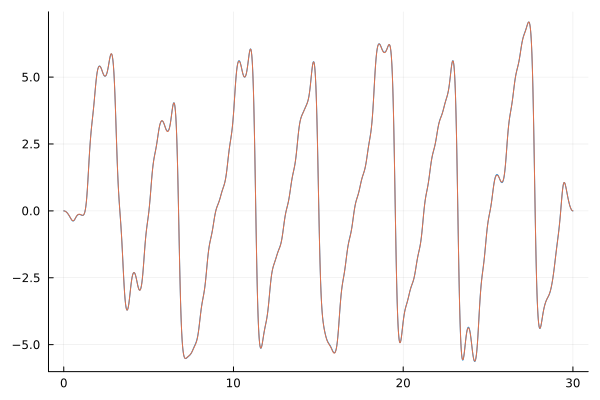

In [129]:
inds = [275,310]#[1,20,40,60,80,100,115]
plot(times,[[pulse(ps[i,:],t) for t in times] for i in inds],label=nothing)

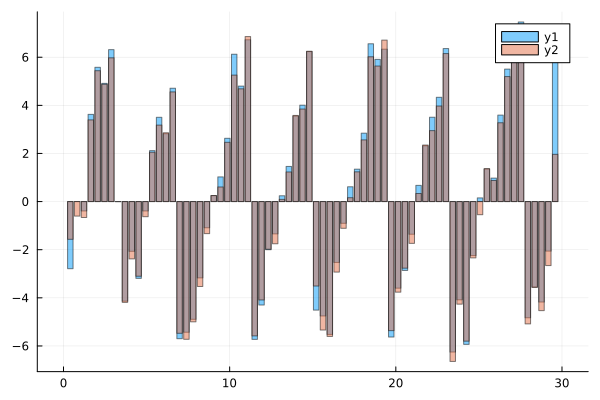

In [122]:
bar(h_times, [ps[end,:],ps[end-80,:]],alpha=0.5)

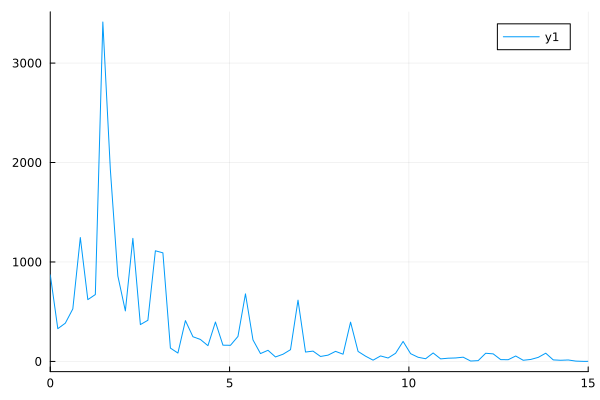

In [118]:
using FFTW
Ts = times[2]
F = fft([pulse(ps[end,:],t) for t in times]) |> fftshift
# F = fft([sin(t) for t in times]) |> fftshift
freqs = fftfreq(length(times), 1/Ts) |> fftshift

p = plot(freqs*2*pi,abs.(F),xlim=(-0.001,15))

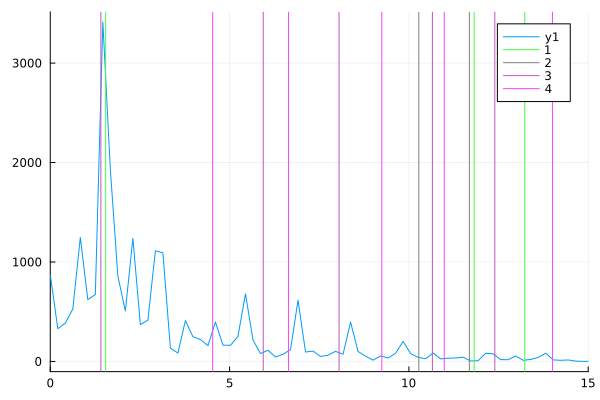

In [119]:
Es = eigvals(Matrix(KinPot12 + Potential3))

DEs = (reshape(Es,289,1) .- reshape(Es,1,289))
M = DEs[1:10,1:10]
# tmp_w = M[tril!(trues(size(M)), -1)] ;
Nlim=4
for tmpN = 1:Nlim
    plot!(M[tmpN+1:end,tmpN],seriestype=:vline,label=tmpN,color=RGB(tmpN/Nlim,1/tmpN,tmpN/Nlim))
end
plot(p)

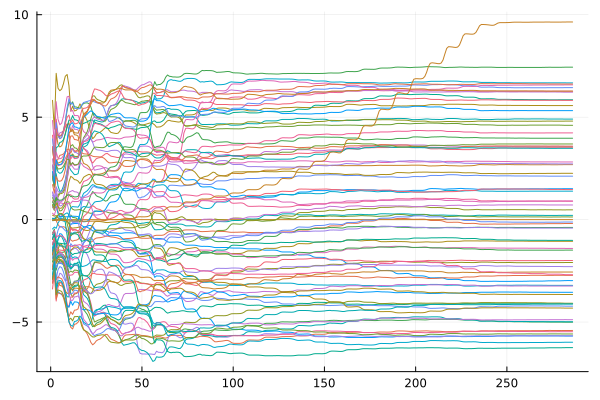

In [127]:
plot(ps[25:end,:],label=nothing)